In [94]:
%pip install pandas
%pip install numpy
%pip install Image
%pip install matplotlib
%pip install sklearn
%pip install transformers
%pip install torch



Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

Note: you may need to restart the kernel to use updated packages.



In [95]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [96]:
# Step 1: Load the Data from CSV
csv_file = "clean_MovieGenre.csv"  # Path to your CSV file
df = pd.read_csv(csv_file)

# Specify the binarized columns
binarized_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 
                     'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 
                     'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']


In [97]:
from tqdm import tqdm
import os
from PIL import Image
import numpy as np

# Load images and labels in batches
num_batches = len(df) // batch_size + 1

images = []
labels = []

for batch_num in tqdm(range(num_batches)):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, len(df))
    
    batch_df = df.iloc[start_idx:end_idx]
    batch_images = []
    batch_labels = []
    
    for index, row in batch_df.iterrows():
        filename = str(row.iloc[0]) + ".jpg"  # Assuming the filenames match the imdbIDs
        label = [int(row[column]) for column in binarized_columns]  # Extract binarized labels for each genre

        image_path = os.path.join(image_folder, filename)
        try:
            image = Image.open(image_path)  # Open image using PIL
            image = image.convert("RGB")  # Convert image to RGB mode if necessary
            image_array = np.array(image)  # Convert PIL Image to numpy array
            batch_images.append(image_array)
            batch_labels.append(label)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")

    # Concatenate the batches of images and labels
    if batch_images:
        images.append(np.array(batch_images))
        labels.append(np.array(batch_labels))

# Concatenate all batches into single numpy arrays
if images:
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)


100%|██████████| 260/260 [03:07<00:00,  1.38it/s]


Images shape: (33275, 268, 182, 3)
Labels shape: (33275, 23)


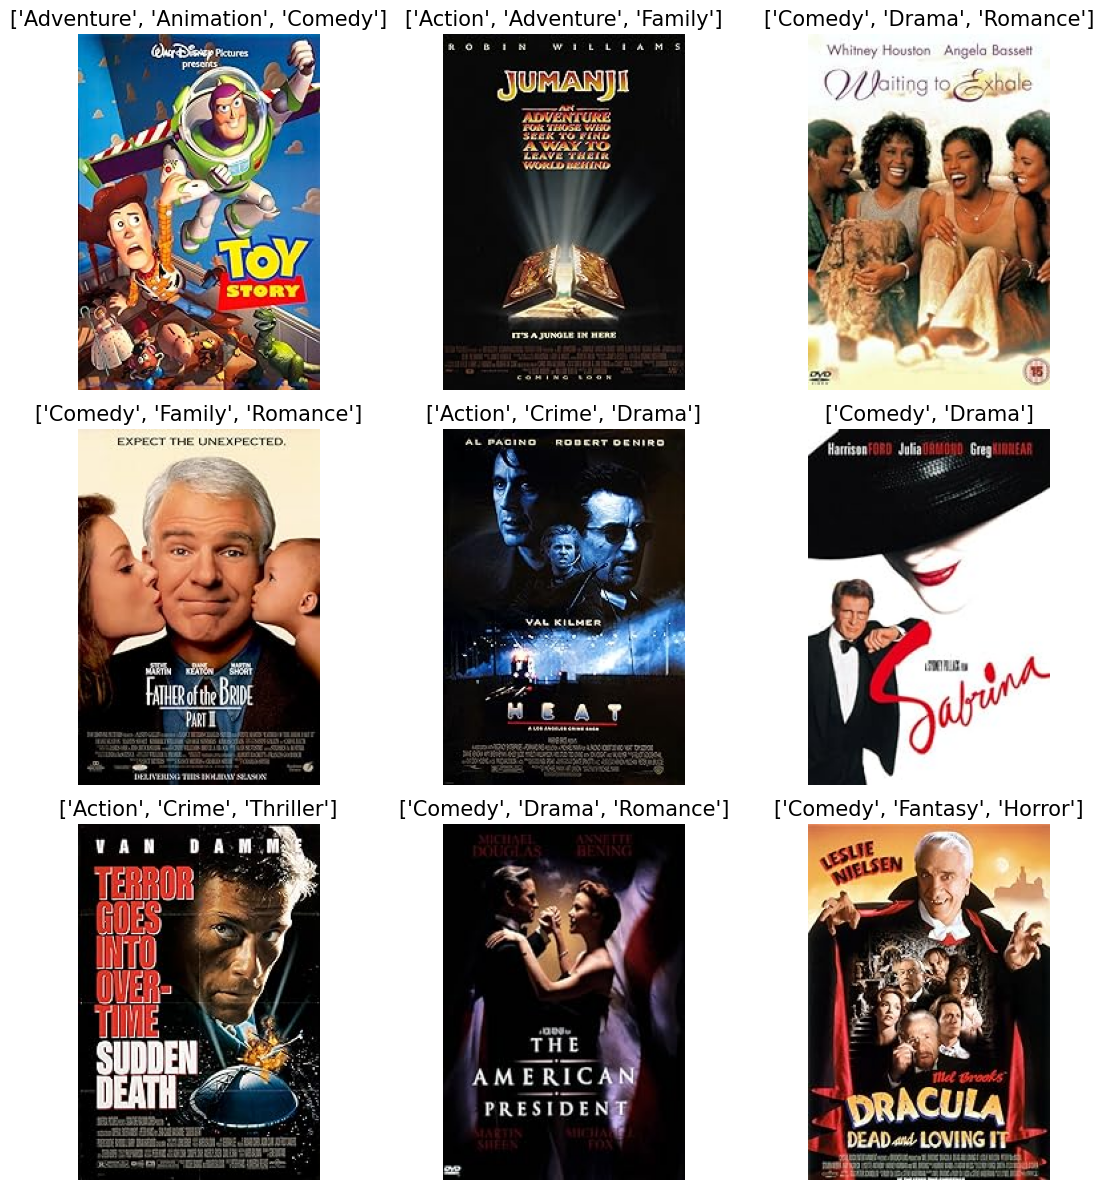

In [98]:
# Print the shapes of the loaded data
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Display sample images
plt.figure(figsize=(12, 12))
for i in range(9):
	ax = plt.subplot(3, 3, i + 1)
	plt.imshow(images[i])
	plt.axis('off')
	plt.title([column for column, label in zip(binarized_columns, labels[i]) if label == 1], fontsize=15)
plt.tight_layout()
plt.show()


In [99]:
from sklearn.model_selection import train_test_split

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Print the shapes of the split datasets
print("Training images shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing images shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training images shape: (26620, 268, 182, 3)
Training labels shape: (26620, 23)
Testing images shape: (6655, 268, 182, 3)
Testing labels shape: (6655, 23)


In [100]:
# Compute the label distribution in y_train
train_label_distribution = np.sum(y_train, axis=0)

# Print the label distribution in y_train
print("Label distribution in y_train:")
for label, count in zip(binarized_columns, train_label_distribution):
    print(f"{label}: {count}")

Label distribution in y_train:
Action: 3608
Adventure: 2567
Animation: 1189
Biography: 1325
Comedy: 8517
Crime: 3496
Documentary: 2629
Drama: 13432
Family: 1417
Fantasy: 1365
Film-Noir: 211
History: 971
Horror: 2646
Music: 858
Musical: 543
Mystery: 1572
Romance: 4038
Sci-Fi: 1349
Short: 623
Sport: 480
Thriller: 3246
War: 755
Western: 503


In [101]:
# Compute the label distribution in y_test
test_label_distribution = np.sum(y_test, axis=0)

# Print the label distribution in y_test
print("\nLabel distribution in y_test:")
for label, count in zip(binarized_columns, test_label_distribution):
    print(f"{label}: {count}")


Label distribution in y_test:
Action: 880
Adventure: 618
Animation: 268
Biography: 360
Comedy: 2110
Crime: 823
Documentary: 619
Drama: 3337
Family: 345
Fantasy: 329
Film-Noir: 58
History: 241
Horror: 715
Music: 199
Musical: 116
Mystery: 401
Romance: 1013
Sci-Fi: 359
Short: 159
Sport: 115
Thriller: 824
War: 198
Western: 104


In [102]:
# Model Specification

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
	'google/vit-base-patch16-224-in21k',
	num_labels=len(binarized_columns),
	problem_type="multi_label_classification"
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

d:\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [105]:
# Perform inference
predicted_probabilities = []

for i in range(0, len(X_test), batch_size):
    # Process batch inputs
    batch_inputs = processor(images=X_test[i:i+batch_size], return_tensors="pt", padding=True)
    batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
    
    with torch.no_grad():
        # Forward pass
        outputs = model(**batch_inputs)
    
    # Get the predicted logits
    logits = outputs.logits
    
    # Convert logits to probabilities using sigmoid
    probabilities = torch.sigmoid(logits)
    
    # Append predicted probabilities for this batch
    predicted_probabilities.append(probabilities.cpu().numpy())

# Concatenate predicted probabilities for all batches
predicted_probabilities = np.concatenate(predicted_probabilities, axis=0)


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


In [127]:
import numpy as np
from sklearn.metrics import f1_score

# Convert lists to NumPy arrays
y_test_np = np.array(y_test)
predicted_probabilities_np = np.array(predicted_probabilities)

# Ensure that the arrays have the appropriate shape
y_test_np = np.vstack([np.array(y) for y in y_test_np])

# Define the threshold for binary classification
threshold = 0.5

# Threshold predicted probabilities to obtain binary predictions
predicted_labels_np = (predicted_probabilities_np > threshold).astype(int)

# Compute the F1 score for each label
f1_scores = []
for i in range(len(binarized_columns)):
    f1 = f1_score(y_test_np[:, i], predicted_labels_np[:, i], average='binary')
    f1_scores.append(f1)

# Print the F1 scores for each label
print("\nF1 scores for each label:")
for label, f1 in zip(binarized_columns, f1_scores):
    print(f"{label}: {f1:.4f}")

# Average the F1 scores to get the overall performance
avg_f1_score = np.mean(f1_scores)
print("\nAverage F1 score:", avg_f1_score)



F1 scores for each label:
Action: 0.1227
Adventure: 0.1557
Animation: 0.0719
Biography: 0.1031
Comedy: 0.4526
Crime: 0.2069
Documentary: 0.1802
Drama: 0.6145
Family: 0.0828
Fantasy: 0.0978
Film-Noir: 0.0098
History: 0.0749
Horror: 0.1358
Music: 0.0567
Musical: 0.0320
Mystery: 0.1005
Romance: 0.2359
Sci-Fi: 0.1108
Short: 0.0401
Sport: 0.0385
Thriller: 0.1897
War: 0.0690
Western: 0.0390

Average F1 score: 0.14003091947852944


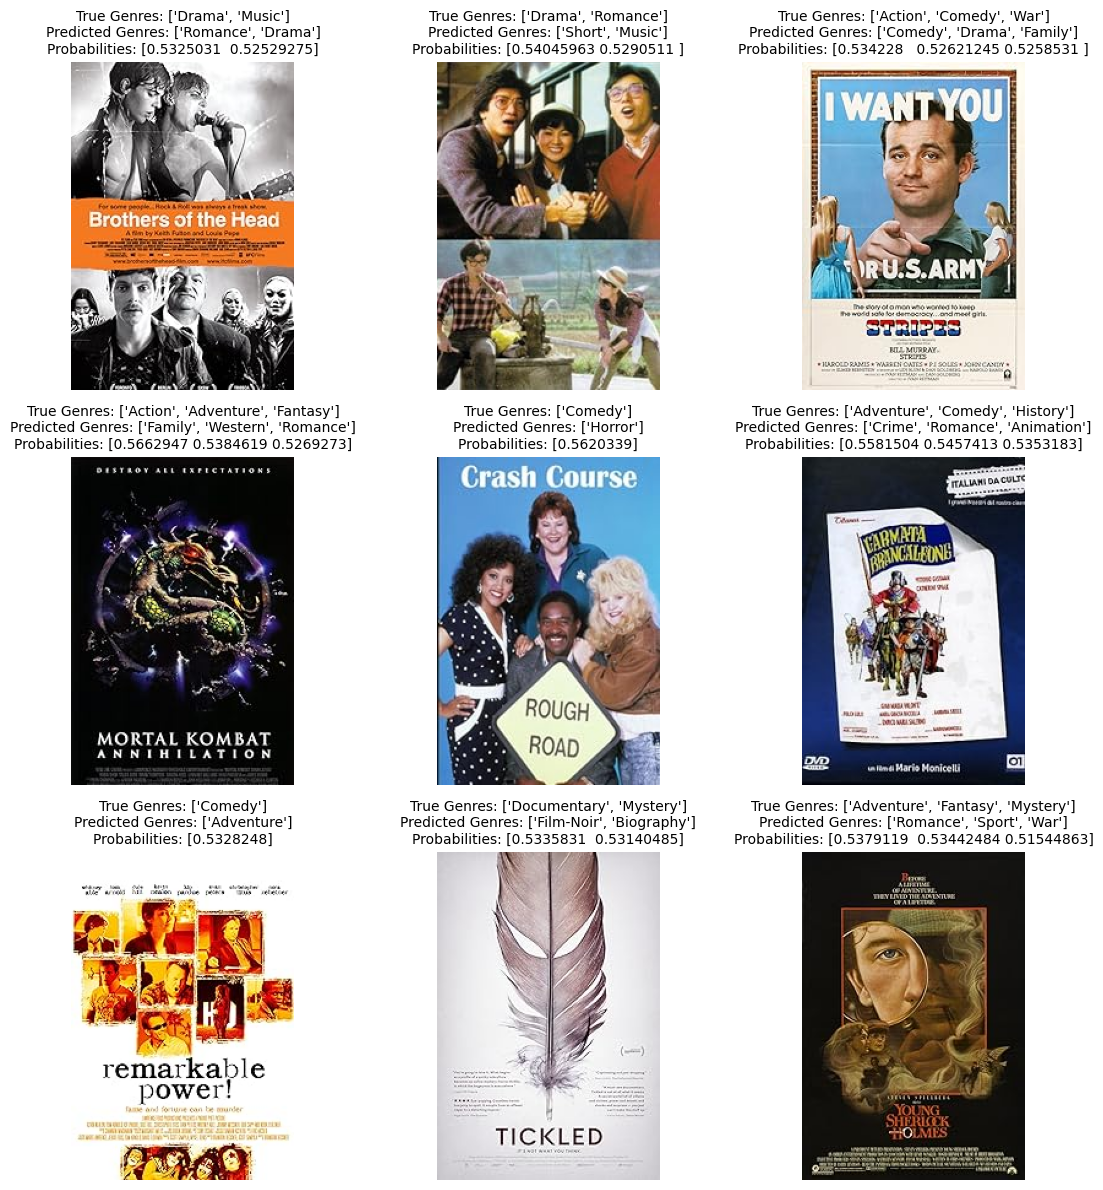

In [134]:
def display(X_test, y_test, predicted_probabilities, binarized_columns, threshold=0.5):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(X_test):
            poster = X_test[idx]
            true_labels = [binarized_columns[i] for i, label in enumerate(y_test[idx]) if label == 1]
            predicted_genre_probabilities = predicted_probabilities[idx]

            # Sort predicted probabilities and select labels based on the number of true labels
            num_true_labels = len(true_labels)
            top_predicted_idx = np.argsort(predicted_genre_probabilities)[::-1][:num_true_labels]
            predicted_genre_labels = [binarized_columns[i] for i in top_predicted_idx]
            top_predicted_probabilities = predicted_genre_probabilities[top_predicted_idx]

            ax.imshow(poster)
            ax.set_title(f"True Genres: {true_labels}\nPredicted Genres: {predicted_genre_labels}\nProbabilities: {top_predicted_probabilities}", fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty subplots
        
    plt.tight_layout()
    plt.show()

display(X_test, y_test, predicted_probabilities, binarized_columns)
